SARIMA-Based Forecasting for Critical Energy Loads

This notebook implements a complete SARIMA-based forecasting pipeline to predict electricity consumption
for three categories of critical loads:

- Very Critical Loads
- Medium Critical Loads
- Low Critical Loads

Input
- Excel file: RnD_CriticalLoadHistory_2023.xlsx
- Time period: January to December 2023
- Time interval: 15-minute resolution
- Load columns: "Very Critical Loads", "Medium Critical Loads", "Low Critical Loads"

Method Overview
1. Load and clean the time series data
2. Visualize full-year and December-only load trends
3. Split each series into training (January to November) and test (December)
4. Check stationarity using the Augmented Dickey-Fuller (ADF) test
5. Plot ACF and PACF to understand temporal dependencies
6. Train separate SARIMA models for each load category
7. Forecast values for December
8. Plot predictions versus actual values
9. Evaluate results using:
   - Mean Absolute Error (MAE)
   - Root Mean Squared Error (RMSE)
10. Export forecast results to CSV files

Output
- Forecast CSV files for each load category (actual vs predicted)
- Plot images:
  - Full-year data with forecast overlay
  - Actual vs forecast for December
  - ACF and PACF plots
- Printed evaluation metrics for each load:
  - MAE
  - RMSE


In [ ]:
# --- Import Required Libraries ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time Series Analysis & Forecasting Tools
from statsmodels.tsa.stattools import adfuller             # For stationarity testing using ADF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For plotting ACF and PACF
from statsmodels.tsa.statespace.sarimax import SARIMAX     # SARIMA model implementation

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error  # To evaluate forecast performance

# Google Colab Drive Access
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive to access files


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_critical_load_data(file_path, target_column):
    """
    Loads and preprocesses critical load time series data from Excel.

    Parameters:
    -----------
    file_path : str
        Full path to the Excel file.
    target_column : str
        Name of the load column to extract.

    Returns:
    --------
    pd.DataFrame
        Cleaned DataFrame with datetime index and one 'Load' column.
    """
    import pandas as pd
    import os

    # Raise error if file does not exist
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Excel file not found at: {file_path}")

    # Read the Excel file, skipping the first row (usually metadata/header)
    df = pd.read_excel(file_path, skiprows=1)

    # Clean up column names: strip whitespace, remove non-breaking spaces and newlines
    df.columns = df.columns.str.strip().str.replace('\xa0', '').str.replace('\n', ' ')

    # Rename the original Excel column names to more meaningful ones
    column_map = {
        'kWh.4': 'Very Critical Loads',
        'kWh.5': 'Medium Critical Loads',
        'kWh.6': 'Low Critical Loads'
    }
    df.rename(columns=column_map, inplace=True)

    # Check for required columns: Timestamp and the specific load column
    if "Timestamp" not in df.columns or target_column not in df.columns:
        raise ValueError(f"Missing expected columns: 'Timestamp' and '{target_column}'")

    # Keep only Timestamp and the target load column
    df = df[["Timestamp", target_column]].copy()
    df.columns = ["Timestamp", "Load"]  # Standardize column names

    # Convert timestamp to datetime and load values to numeric
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="mixed")
    df["Load"] = pd.to_numeric(df["Load"], errors="coerce")

    # Drop rows with missing or invalid data
    df.dropna(inplace=True)

    # Set the datetime column as the DataFrame index
    df.set_index("Timestamp", inplace=True)

    return df


In [ ]:
def plot_critical_loads_separately(df_very, df_medium, df_low, sample_step=20):
    """
    Plots the full-year critical load time series for each category (Very, Medium, Low).
    Saves each plot as a PNG file after downsampling for clarity.

    Parameters:
    -----------
    df_very : pd.DataFrame
        DataFrame of Very Critical Loads.
    df_medium : pd.DataFrame
        DataFrame of Medium Critical Loads.
    df_low : pd.DataFrame
        DataFrame of Low Critical Loads.
    sample_step : int
        Step size for downsampling to reduce clutter in plots (default=20).
    """

    # --- Very Critical Loads ---
    plt.figure(figsize=(14, 4))
    sampled_very = df_very.iloc[::sample_step]  # Downsample to reduce visual density
    plt.plot(sampled_very.index, sampled_very["Load"], color='red',
             linewidth=1.0, alpha=0.8)
    plt.title("Very Critical Loads", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Load (kWh)", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.savefig("very_critical_loads_full_year.png", dpi=150)
    plt.show()

    # --- Medium Critical Loads ---
    plt.figure(figsize=(14, 4))
    sampled_medium = df_medium.iloc[::sample_step]  # Downsample
    plt.plot(sampled_medium.index, sampled_medium["Load"], color='orange',
             linewidth=1.0, alpha=0.8)
    plt.title("Medium Critical Loads", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Load (kWh)", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.savefig("medium_critical_loads_full_year.png", dpi=150)
    plt.show()

    # --- Low Critical Loads ---
    plt.figure(figsize=(14, 4))
    sampled_low = df_low.iloc[::sample_step]  # Downsample
    plt.plot(sampled_low.index, sampled_low["Load"], color='green',
             linewidth=1.0, alpha=0.8)
    plt.title("Low Critical Loads", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Load (kWh)", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.savefig("low_critical_loads_full_year.png", dpi=150)
    plt.show()


In [ ]:
def plot_december_loads(df_very, df_medium, df_low, sample_step=10):
    """
    Filters and plots December 2023 load data for Very, Medium, and Low Critical Loads.
    Saves each plot as a PNG file. Downsampling is applied for clarity.

    Parameters:
    -----------
    df_very : pd.DataFrame
        DataFrame of Very Critical Loads.
    df_medium : pd.DataFrame
        DataFrame of Medium Critical Loads.
    df_low : pd.DataFrame
        DataFrame of Low Critical Loads.
    sample_step : int
        Step size for downsampling (default=10).
    """

    # --- Filter only December entries and downsample ---
    dec_very = df_very[df_very.index.month == 12].iloc[::sample_step]
    dec_medium = df_medium[df_medium.index.month == 12].iloc[::sample_step]
    dec_low = df_low[df_low.index.month == 12].iloc[::sample_step]

    # --- Very Critical Loads (December) ---
    plt.figure(figsize=(14, 4))
    plt.plot(dec_very.index, dec_very["Load"], color='red', linewidth=1.2, alpha=0.8)
    plt.title("Very Critical Loads – December 2023", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Load (kWh)", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.savefig("very_critical_loads_december.png", dpi=150)
    plt.show()

    # --- Medium Critical Loads (December) ---
    plt.figure(figsize=(14, 4))
    plt.plot(dec_medium.index, dec_medium["Load"], color='orange', linewidth=1.2, alpha=0.8)
    plt.title("Medium Critical Loads – December 2023", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Load (kWh)", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.savefig("medium_critical_loads_december.png", dpi=150)
    plt.show()

    # --- Low Critical Loads (December) ---
    plt.figure(figsize=(14, 4))
    plt.plot(dec_low.index, dec_low["Load"], color='green', linewidth=1.2, alpha=0.8)
    plt.title("Low Critical Loads – December 2023", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Load (kWh)", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.savefig("low_critical_loads_december.png", dpi=150)
    plt.show()


In [ ]:
def split_train_test_december(df, target_column):
    """
    Splits the critical load data into training (Jan–Nov) and test (Dec) sets.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with a datetime index and a 'Load' column.
    target_column : str
        Name of the load type for print messages (e.g., "Very Critical Loads").

    Returns:
    --------
    train_df : pd.DataFrame
        Data from January 1 to November 30, 2023.
    test_df : pd.DataFrame
        Data from December 1 to December 31, 2023.
    """

    # --- Create training set: all records before December 1st ---
    train_df = df[df.index < "2023-12-01"].copy()

    # --- Create test set: all records from December 1st onward ---
    test_df = df[df.index >= "2023-12-01"].copy()

    # --- Print summary of split ---
    print(f"\nSplitting '{target_column}' into train and test sets...")
    print(f"Total records: {len(df)} | Train: {len(train_df)} | Test (Dec): {len(test_df)}")

    return train_df, test_df


In [ ]:
def check_stationarity_adf(series, label):
    """
    Performs the Augmented Dickey-Fuller (ADF) test to assess stationarity.

    Parameters
    ----------
    series : pd.Series
        Time series data to test.
    label : str
        Label for the series (used in printed output).

    Returns
    -------
    None
    """
    print(f"\n[ADF Test] Checking stationarity for {label}...")
    result = adfuller(series, autolag='AIC')

    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("=> Stationary (reject H0)")
    else:
        print("=> Non-stationary (fail to reject H0)")


In [ ]:
def plot_acf_pacf(series, lags=96, title_prefix=""):
    """
    Plots and saves the ACF and PACF of a time series.

    Parameters:
    -----------
    series : pd.Series
        Time series data to analyze.
    lags : int
        Number of lags to display in the plots (default=96).
    title_prefix : str
        Prefix for plot titles and saved filenames.
    """

    # --- ACF Plot ---
    plt.figure(figsize=(12, 4))
    plot_acf(series, lags=lags)  # Plot autocorrelation
    plt.title(f"{title_prefix} - ACF")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title_prefix.lower().replace(' ', '_')}_acf.png")  # Save plot to file
    plt.show()

    # --- PACF Plot ---
    plt.figure(figsize=(12, 4))
    plot_pacf(series, lags=lags)  # Plot partial autocorrelation
    plt.title(f"{title_prefix} - PACF")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title_prefix.lower().replace(' ', '_')}_pacf.png")  # Save plot to file
    plt.show()


In [ ]:
def train_sarima_very(train_series, order, seasonal_order):
    """
    Trains a SARIMA model on Very Critical Loads.

    Parameters:
    -----------
    train_series : pd.Series
        The training time series data (Very Critical Loads).
    order : tuple
        ARIMA order (p, d, q).
    seasonal_order : tuple
        Seasonal ARIMA order (P, D, Q, s).

    Returns:
    --------
    results : SARIMAXResults
        Fitted SARIMA model results.
    """
    print(f"\n Training SARIMA{order}x{seasonal_order} for Very Critical Loads...")

    # Instantiate the SARIMA model
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)

    # Fit the model to the training data
    results = model.fit(disp=False)

    print(" Model training complete for Very Critical Loads.")
    print(results.summary())  # Print model summary (AIC, BIC, coefficients, etc.)

    return results


def train_sarima_medium(train_series, order, seasonal_order):
    """
    Trains a SARIMA model on Medium Critical Loads.
    Same structure as the 'very' function above.
    """
    print(f"\n Training SARIMA{order}x{seasonal_order} for Medium Critical Loads...")

    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    print(" Model training complete for Medium Critical Loads.")
    print(results.summary())

    return results


def train_sarima_low(train_series, order, seasonal_order):
    """
    Trains a SARIMA model on Low Critical Loads.
    Same structure as the 'very' and 'medium' functions above.
    """
    print(f"\n Training SARIMA{order}x{seasonal_order} for Low Critical Loads...")

    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    print(" Model training complete for Low Critical Loads.")
    print(results.summary())

    return results


In [ ]:
def forecast_very(model, steps, test_index):
    """
    Forecasts future values for Very Critical Loads using the trained SARIMA model.

    Parameters:
    -----------
    model : SARIMAXResults
        Fitted SARIMA model.
    steps : int
        Number of future steps to forecast.
    test_index : pd.DatetimeIndex
        Index to assign to the forecasted values (typically December timestamps).

    Returns:
    --------
    forecast : pd.Series
        Forecasted values with datetime index.
    """
    print("\nForecasting December for Very Critical Loads...")

    # Generate forecast
    forecast = model.forecast(steps=steps)

    # Assign correct datetime index to forecast
    forecast.index = test_index

    print("Forecast complete for Very Critical Loads.")
    return forecast


def forecast_medium(model, steps, test_index):
    """
    Forecasts future values for Medium Critical Loads using the trained SARIMA model.
    """
    print("\nForecasting December for Medium Critical Loads...")
    forecast = model.forecast(steps=steps)
    forecast.index = test_index
    print("Forecast complete for Medium Critical Loads.")
    return forecast


def forecast_low(model, steps, test_index):
    """
    Forecasts future values for Low Critical Loads using the trained SARIMA model.
    """
    print("\nForecasting December for Low Critical Loads...")
    forecast = model.forecast(steps=steps)
    forecast.index = test_index
    print("Forecast complete for Low Critical Loads.")
    return forecast


In [ ]:
def plot_forecast_very(y_true, y_pred, sample_step=10):
    """
    Plots the forecast vs actual values for Very Critical Loads in December.

    Parameters:
    -----------
    y_true : pd.Series
        Ground truth values for December.
    y_pred : pd.Series
        Forecasted values from the SARIMA model.
    sample_step : int
        Step size for downsampling in the plot (default=10).
    """
    print("Plotting forecast for Very Critical Loads...")
    plt.figure(figsize=(14, 5))

    # Plot actual values (downsampled)
    plt.plot(y_true.index[::sample_step], y_true.values[::sample_step],
             label="Actual", color="blue", linewidth=1.2, alpha=0.8)

    # Plot forecasted values (downsampled)
    plt.plot(y_pred.index[::sample_step], y_pred.values[::sample_step],
             label="Forecast", color="orange", linewidth=2)

    plt.title("Very Critical Loads – December Forecast vs Actual", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Load (kWh)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.savefig("very_critical_loads_december_forecast.png", dpi=150)
    plt.show()


def plot_forecast_medium(y_true, y_pred, sample_step=10):
    """
    Plots the forecast vs actual values for Medium Critical Loads in December.
    """
    print("Plotting forecast for Medium Critical Loads...")
    plt.figure(figsize=(14, 5))
    plt.plot(y_true.index[::sample_step], y_true.values[::sample_step],
             label="Actual", color="blue", linewidth=1.2, alpha=0.8)
    plt.plot(y_pred.index[::sample_step], y_pred.values[::sample_step],
             label="Forecast", color="orange", linewidth=2)
    plt.title("Medium Critical Loads – December Forecast vs Actual", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Load (kWh)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.savefig("medium_critical_loads_december_forecast.png", dpi=150)
    plt.show()


def plot_forecast_low(y_true, y_pred, sample_step=10):
    """
    Plots the forecast vs actual values for Low Critical Loads in December.
    """
    print("Plotting forecast for Low Critical Loads...")
    plt.figure(figsize=(14, 5))
    plt.plot(y_true.index[::sample_step], y_true.values[::sample_step],
             label="Actual", color="blue", linewidth=1.2, alpha=0.8)
    plt.plot(y_pred.index[::sample_step], y_pred.values[::sample_step],
             label="Forecast", color="orange", linewidth=2)
    plt.title("Low Critical Loads – December Forecast vs Actual", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Load (kWh)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.savefig("low_critical_loads_december_forecast.png", dpi=150)
    plt.show()


In [ ]:
def evaluate_very(y_true, y_pred):
    """
    Evaluates the SARIMA forecast for Very Critical Loads using MAE and RMSE.

    Parameters:
    -----------
    y_true : pd.Series
        Actual observed values for December.
    y_pred : pd.Series
        Forecasted values from the SARIMA model.
    """
    print("Evaluating forecast for Very Critical Loads...")

    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)

    # Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Print results
    print(f"MAE:  {mae:.4f} kWh")
    print(f"RMSE: {rmse:.4f} kWh")


def evaluate_medium(y_true, y_pred):
    """
    Evaluates the SARIMA forecast for Medium Critical Loads using MAE and RMSE.
    """
    print("Evaluating forecast for Medium Critical Loads...")
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"MAE:  {mae:.4f} kWh")
    print(f"RMSE: {rmse:.4f} kWh")


def evaluate_low(y_true, y_pred):
    """
    Evaluates the SARIMA forecast for Low Critical Loads using MAE and RMSE.
    """
    print("Evaluating forecast for Low Critical Loads...")
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"MAE:  {mae:.4f} kWh")
    print(f"RMSE: {rmse:.4f} kWh")


In [ ]:
def plot_full_year_with_forecast(full_series, forecast_series, title, save_as, sample_step=20):
    """
    Plots the full year of actual data along with the December SARIMA forecast.

    Parameters:
    -----------
    full_series : pd.Series
        Actual values for the entire year (used for context).
    forecast_series : pd.Series
        Forecasted values for December from the SARIMA model.
    title : str
        Title for the plot.
    save_as : str
        Filename to save the plot (e.g., 'very_forecast_full_year.png').
    sample_step : int
        Step size for downsampling the data (default=20).
    """
    print(f"Plotting full year + forecast for {title}...")

    # Downsample actual and forecast series for readability in the plot
    sampled_full = full_series.iloc[::sample_step]
    sampled_forecast = forecast_series.iloc[::sample_step]

    # --- Plotting ---
    plt.figure(figsize=(14, 5))

    # Actual full-year data (blue line)
    plt.plot(sampled_full.index, sampled_full.values,
             label="Actual (Full Year)", color="blue", linewidth=1)

    # December forecast overlay (orange line)
    plt.plot(sampled_forecast.index, sampled_forecast.values,
             label="SARIMA Forecast (Dec)", color="orange", linewidth=2)

    plt.title(f"{title} – Full Year with December Forecast")
    plt.xlabel("Date")
    plt.ylabel("Load (kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_as)
    plt.show()


In [ ]:
def export_forecast_to_csv(y_true, y_pred, filename):
    """
    Exports the actual and predicted load values to a CSV file.

    Parameters:
    -----------
    y_true : pd.Series
        Actual load values (ground truth).
    y_pred : pd.Series
        Forecasted load values from the SARIMA model.
    filename : str
        Output CSV file path.
    """
    # Create a DataFrame with timestamp, actual, and predicted values
    df_export = pd.DataFrame({
        "Timestamp": y_true.index,
        "Actual_Load_kWh": y_true.values,
        "Predicted_Load_kWh": y_pred.values
    })

    # Save the DataFrame to a CSV file
    df_export.to_csv(filename, index=False)
    print(f"Saved: {filename}")


=== Critical Load Forecasting with SARIMA ===

[Step 1] Loading Very Critical Loads...
[Step 2] Loading Medium Critical Loads...
[Step 3] Loading Low Critical Loads...
[Step 4] Visualizing all critical loads (separately)...


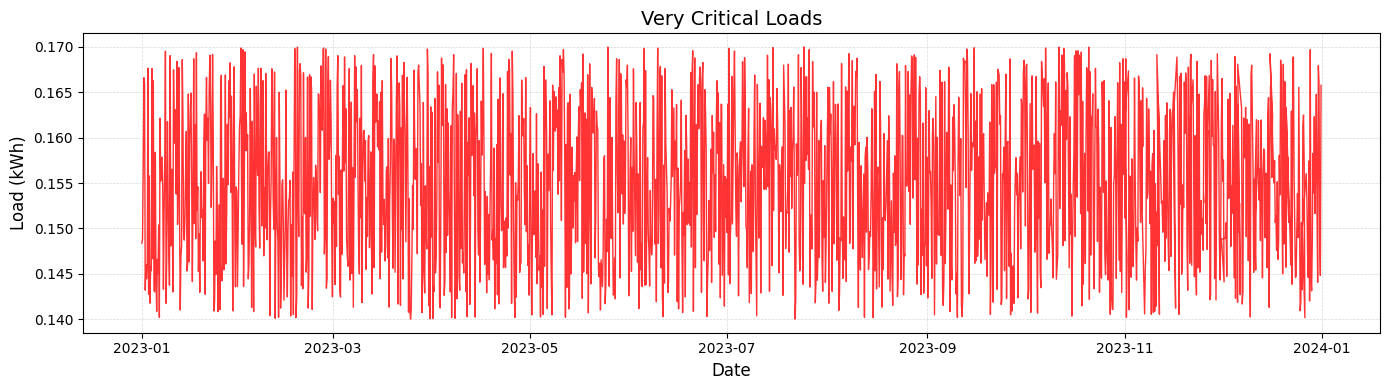

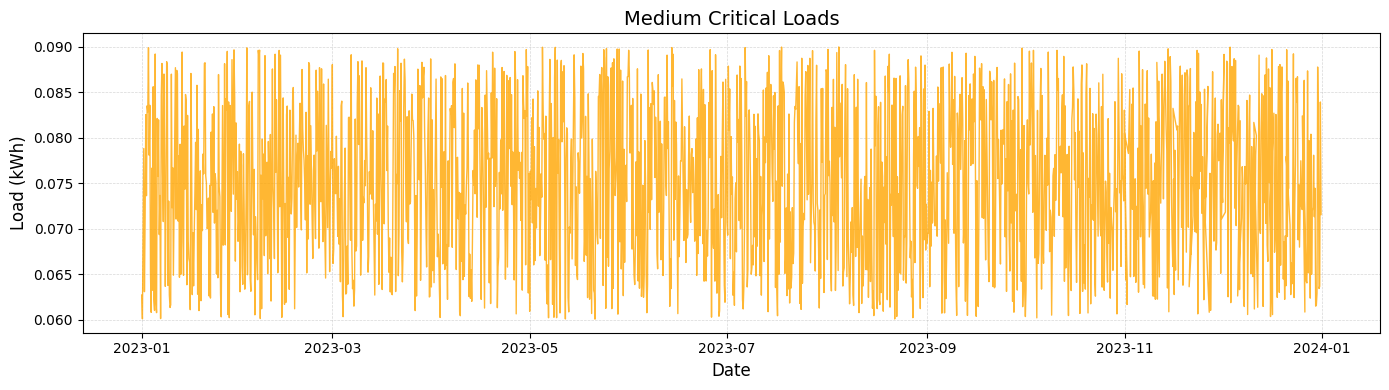

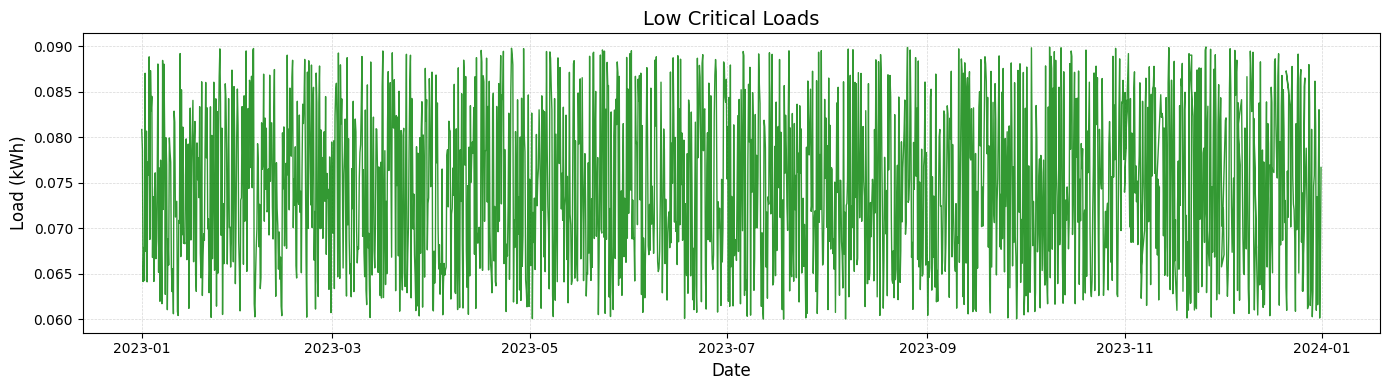

[Step 5] Visualizing only December loads...


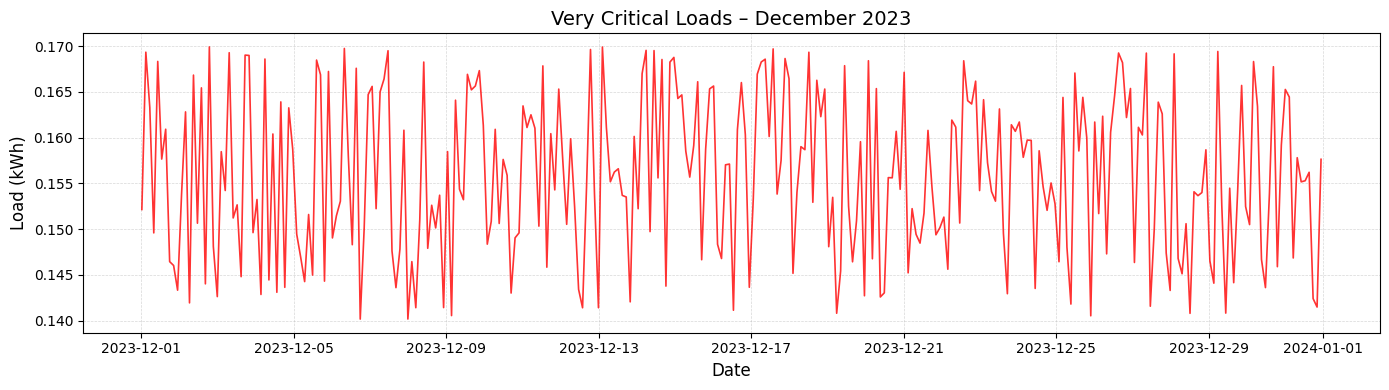

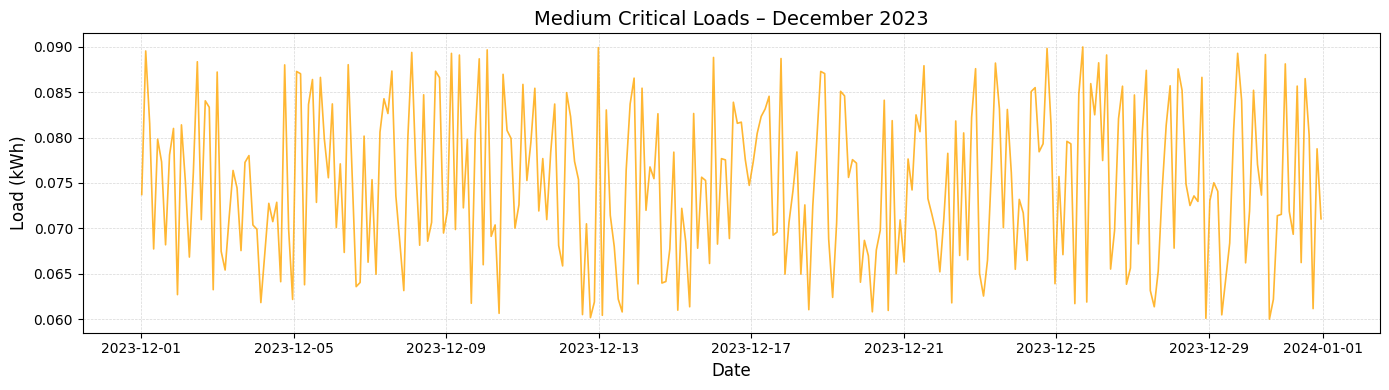

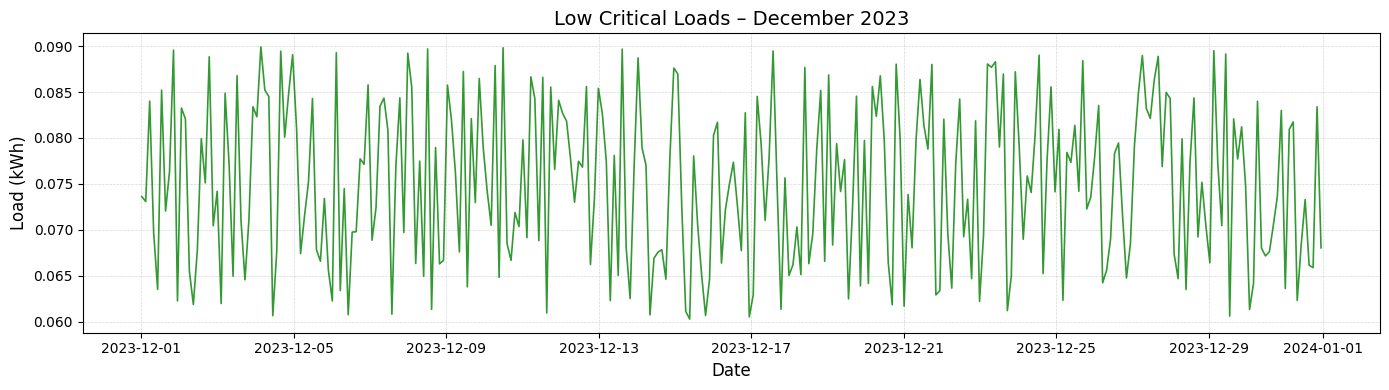

[Step 6] Splitting datasets into train (Jan–Nov) and test (Dec)...

Splitting 'Very Critical Loads' into train and test sets...
Total records: 35040 | Train: 32065 | Test (Dec): 2975

Splitting 'Medium Critical Loads' into train and test sets...
Total records: 35040 | Train: 32065 | Test (Dec): 2975

Splitting 'Low Critical Loads' into train and test sets...
Total records: 35040 | Train: 32065 | Test (Dec): 2975
[Step 7] Checking stationarity of critical loads...

[ADF Test] Checking stationarity for Very Critical Loads...
ADF Statistic: -177.2339
p-value: 0.0000
=> Stationary (reject H0)

[ADF Test] Checking stationarity for Medium Critical Loads...
ADF Statistic: -127.9826
p-value: 0.0000
=> Stationary (reject H0)

[ADF Test] Checking stationarity for Low Critical Loads...
ADF Statistic: -58.4037
p-value: 0.0000
=> Stationary (reject H0)
[Step 8] Plotting ACF and PACF for critical loads...


<Figure size 1200x400 with 0 Axes>

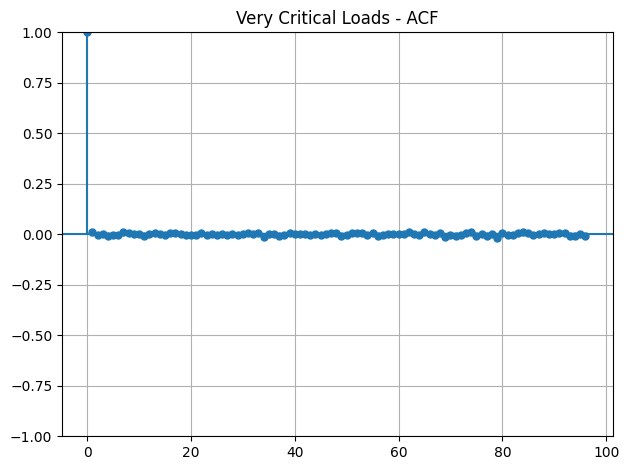

<Figure size 1200x400 with 0 Axes>

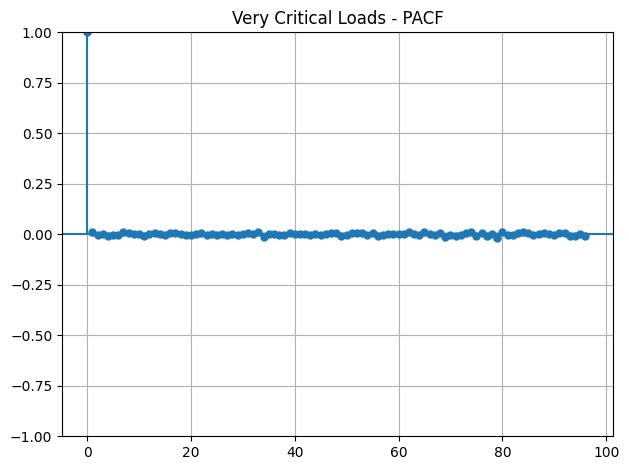

<Figure size 1200x400 with 0 Axes>

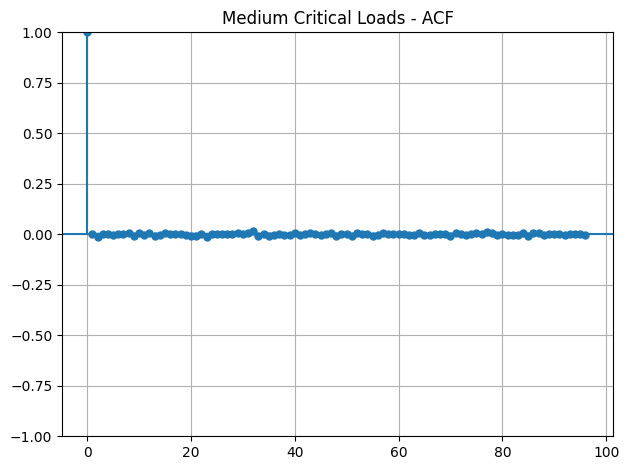

<Figure size 1200x400 with 0 Axes>

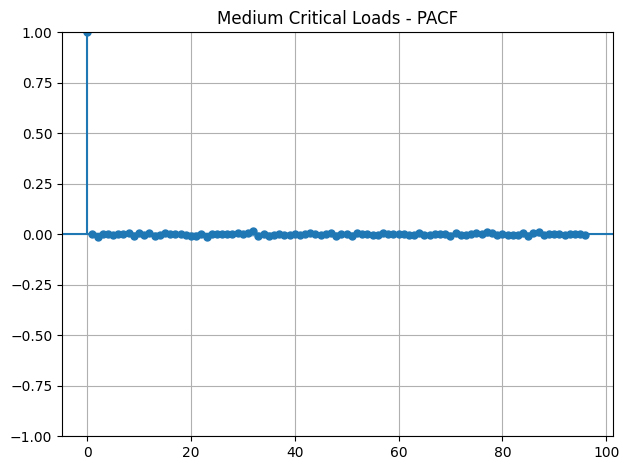

<Figure size 1200x400 with 0 Axes>

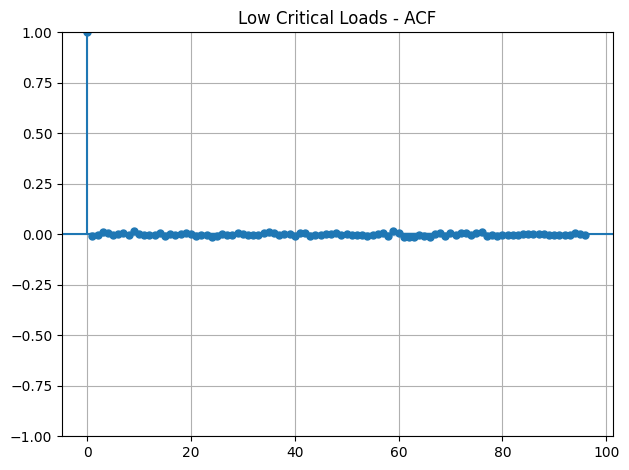

<Figure size 1200x400 with 0 Axes>

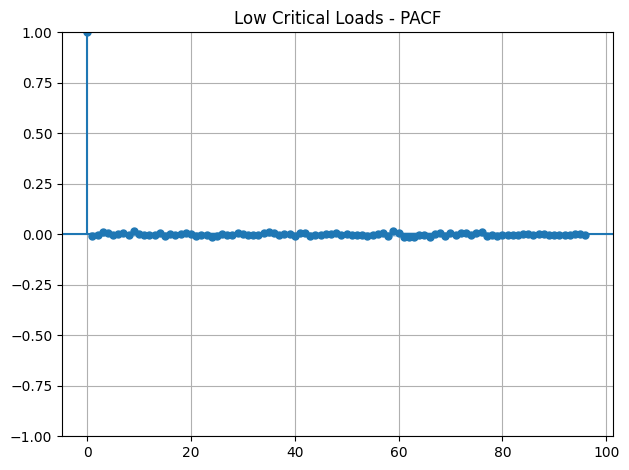


[Step 9] Fitting SARIMA models to each critical load category...


 Training SARIMA(1, 0, 1)x(0, 0, 0, 96) for Very Critical Loads...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Model training complete for Very Critical Loads.
                               SARIMAX Results                                
Dep. Variable:                   Load   No. Observations:                32065
Model:               SARIMAX(1, 0, 1)   Log Likelihood              106756.775
Date:                Mon, 04 Aug 2025   AIC                        -213507.550
Time:                        10:32:44   BIC                        -213482.424
Sample:                             0   HQIC                       -213499.513
                              - 32065                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.04e-06   9.66e+05      0.000       1.000       1.000
ma.L1         -0.9994      0.003   -366.218      0.000      -1.005      -0.994
si

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

 Model training complete for Medium Critical Loads.
                               SARIMAX Results                                
Dep. Variable:                   Load   No. Observations:                32065
Model:               SARIMAX(1, 0, 1)   Log Likelihood              106801.892
Date:                Mon, 04 Aug 2025   AIC                        -213597.783
Time:                        10:32:57   BIC                        -213572.657
Sample:                             0   HQIC                       -213589.747
                              - 32065                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.42e-06   7.05e+05      0.000       1.000       1.000
ma.L1         -0.9997      0.006   -165.329      0.000      -1.012      -0.988


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Model training complete for Low Critical Loads.
                               SARIMAX Results                                
Dep. Variable:                   Load   No. Observations:                32065
Model:               SARIMAX(1, 0, 1)   Log Likelihood              106733.263
Date:                Mon, 04 Aug 2025   AIC                        -213460.527
Time:                        10:33:08   BIC                        -213435.401
Sample:                             0   HQIC                       -213452.490
                              - 32065                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.58e-06   6.34e+05      0.000       1.000       1.000
ma.L1         -1.0005      0.003   -324.706      0.000      -1.007      -0.995
sig

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


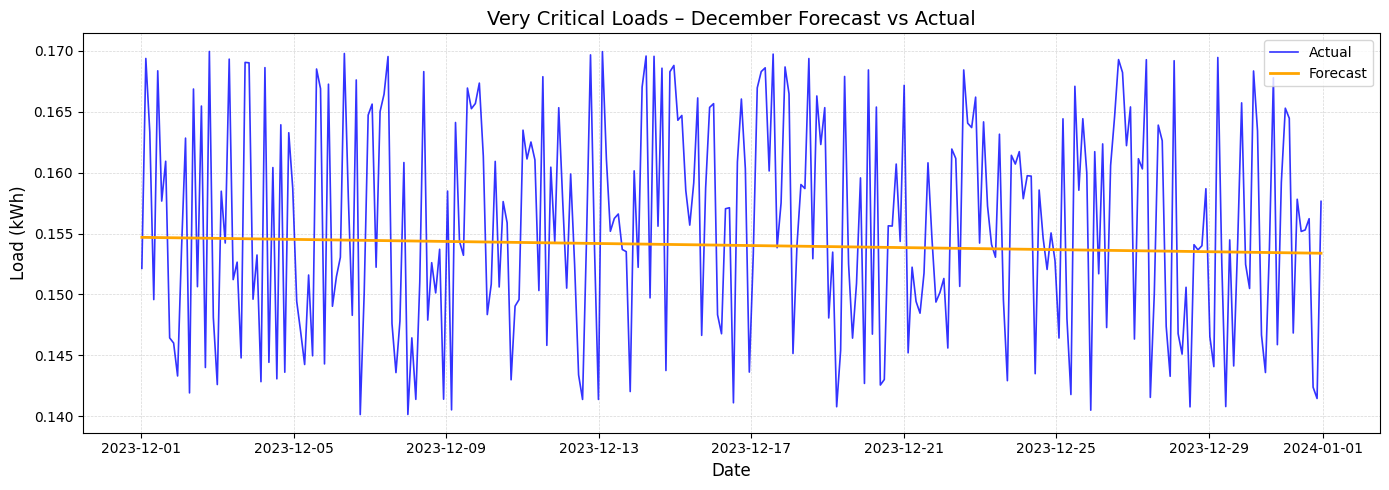

Plotting forecast for Medium Critical Loads...


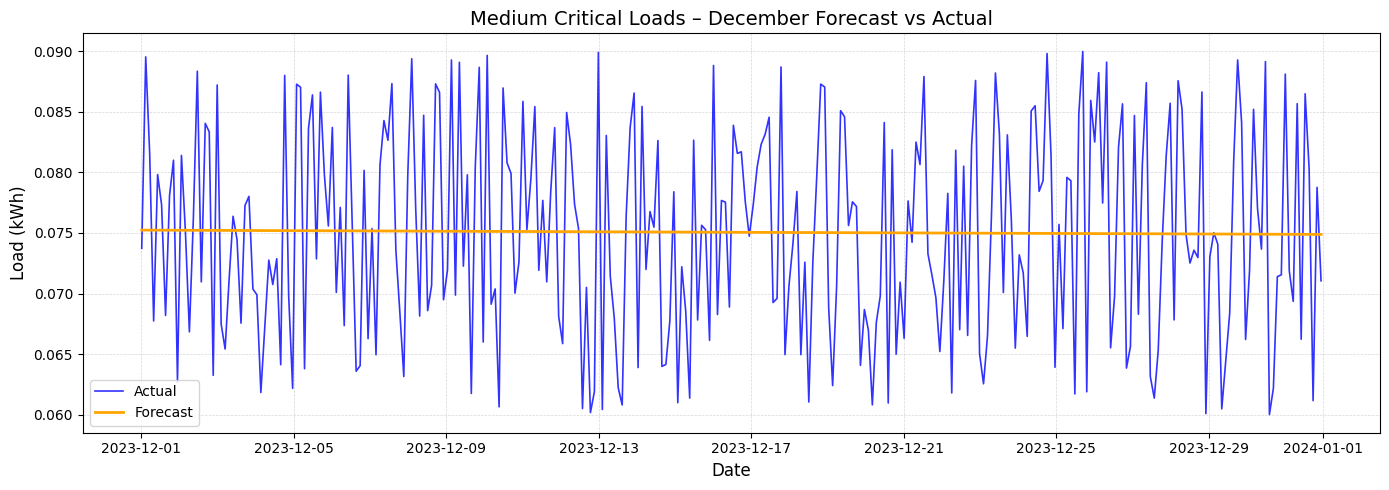

Plotting forecast for Low Critical Loads...


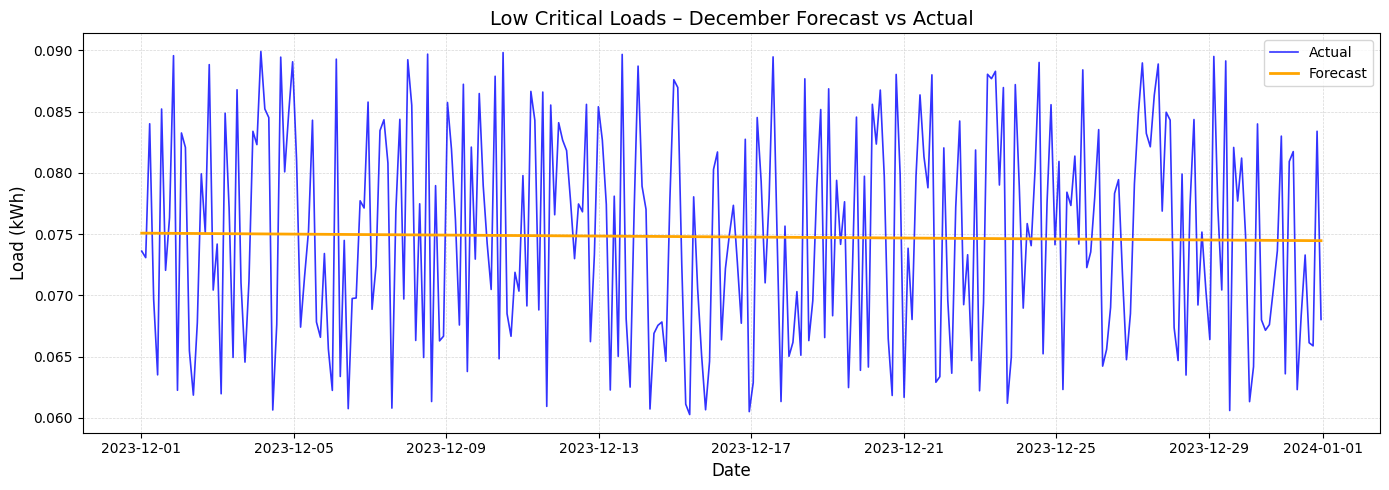


[Step 12] Evaluating forecast accuracy...

Evaluating forecast for Very Critical Loads...
MAE:  0.0075 kWh
RMSE: 0.0087 kWh
Evaluating forecast for Medium Critical Loads...
MAE:  0.0074 kWh
RMSE: 0.0086 kWh
Evaluating forecast for Low Critical Loads...
MAE:  0.0075 kWh
RMSE: 0.0087 kWh

[Step 13] Plotting full-year series with forecast overlays...

Plotting full year + forecast for Very Critical Loads...


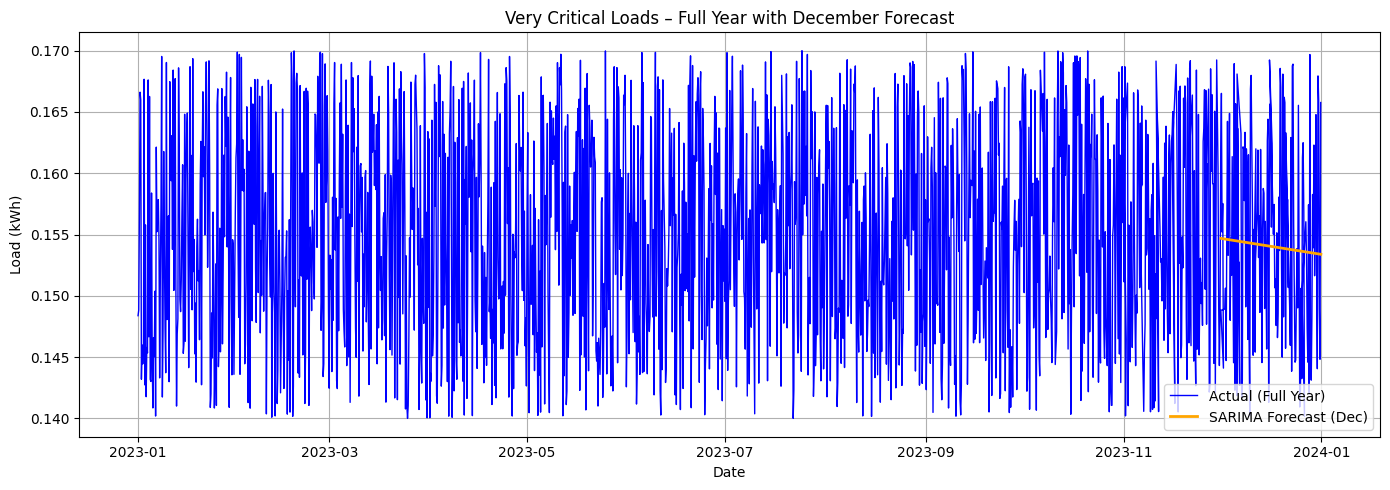

Plotting full year + forecast for Medium Critical Loads...


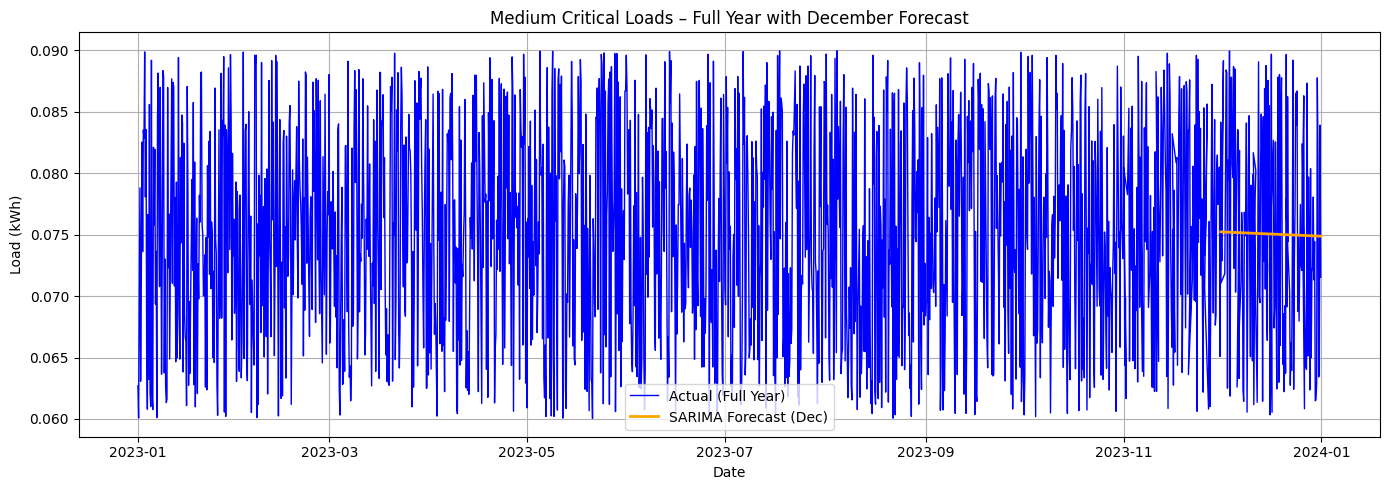

Plotting full year + forecast for Low Critical Loads...


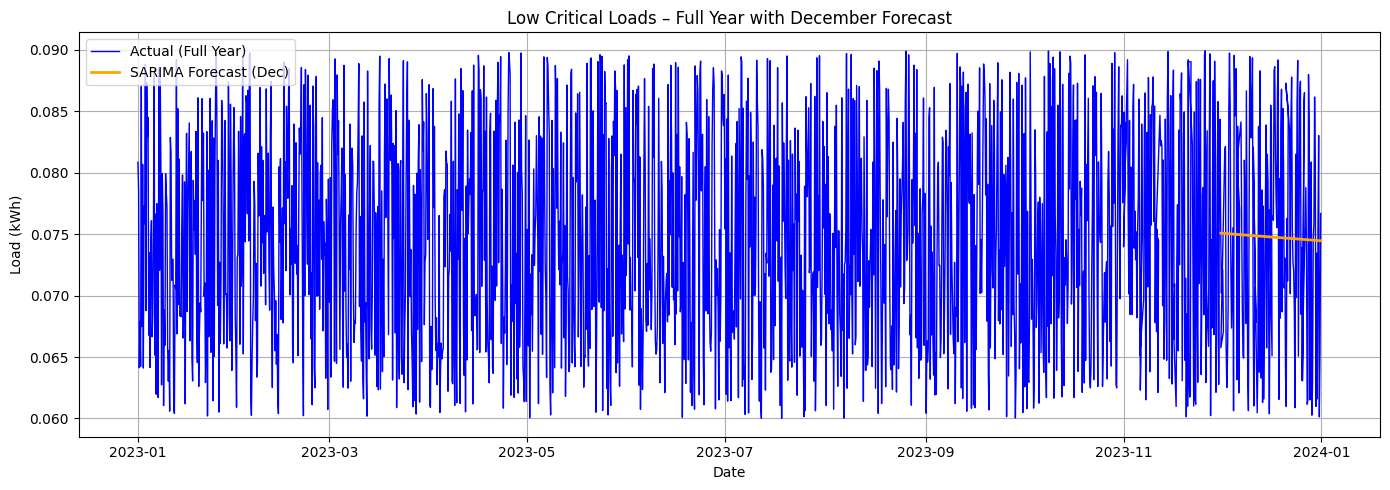


[Step 14] Exporting December predictions to CSV...

Saved: very_critical_sarima_forecast.csv
Saved: medium_critical_sarima_forecast.csv
Saved: low_critical_sarima_forecast.csv


In [ ]:
def main():
    print("=== Critical Load Forecasting with SARIMA ===\n")

    # === Step 0: File path to dataset ===
    file_path = "/content/drive/MyDrive/datasets/RnD_CriticalLoadHistory_2023.xlsx"

    # === Step 1–3: Load each Critical Load category from Excel ===
    print("[Step 1] Loading Very Critical Loads...")
    df_very = load_critical_load_data(file_path, "Very Critical Loads")

    print("[Step 2] Loading Medium Critical Loads...")
    df_medium = load_critical_load_data(file_path, "Medium Critical Loads")

    print("[Step 3] Loading Low Critical Loads...")
    df_low = load_critical_load_data(file_path, "Low Critical Loads")

    # === Step 4: Visualize full-year load trends ===
    print("[Step 4] Visualizing all critical loads (separately)...")
    plot_critical_loads_separately(df_very, df_medium, df_low)

    # === Step 5: Visualize only December ===
    print("[Step 5] Visualizing only December loads...")
    plot_december_loads(df_very, df_medium, df_low)

    # === Step 6: Split into Train (Jan–Nov) and Test (Dec) ===
    print("[Step 6] Splitting datasets into train (Jan–Nov) and test (Dec)...")
    train_very, test_very = split_train_test_december(df_very, "Very Critical Loads")
    train_medium, test_medium = split_train_test_december(df_medium, "Medium Critical Loads")
    train_low, test_low = split_train_test_december(df_low, "Low Critical Loads")

    # === Step 7: ADF Stationarity Test ===
    print("[Step 7] Checking stationarity of critical loads...")
    check_stationarity_adf(train_very["Load"], "Very Critical Loads")
    check_stationarity_adf(train_medium["Load"], "Medium Critical Loads")
    check_stationarity_adf(train_low["Load"], "Low Critical Loads")

    # === Step 8: Plot ACF and PACF ===
    print("[Step 8] Plotting ACF and PACF for critical loads...")
    plot_acf_pacf(train_very["Load"], lags=96, title_prefix="Very Critical Loads")
    plot_acf_pacf(train_medium["Load"], lags=96, title_prefix="Medium Critical Loads")
    plot_acf_pacf(train_low["Load"], lags=96, title_prefix="Low Critical Loads")

    # === Step 9: Fit SARIMA Models ===
    print("\n[Step 9] Fitting SARIMA models to each critical load category...\n")
    order = (1, 0, 1)
    seasonal_order = (0, 0, 0, 96)

    sarima_model_very = train_sarima_very(train_very["Load"], order, seasonal_order)
    sarima_model_medium = train_sarima_medium(train_medium["Load"], order, seasonal_order)
    sarima_model_low = train_sarima_low(train_low["Load"], order, seasonal_order)

    # === Step 10: Forecast December 2023 ===
    print("\n[Step 10] Forecasting December 2023 for all loads...\n")
    forecast_steps = len(test_very)

    forecast_very_dec = forecast_very(sarima_model_very, forecast_steps, test_very.index)
    forecast_medium_dec = forecast_medium(sarima_model_medium, forecast_steps, test_medium.index)
    forecast_low_dec = forecast_low(sarima_model_low, forecast_steps, test_low.index)

    # === Step 11: Plot Actual vs Forecast for December ===
    print("\n[Step 11] Plotting actual vs forecasted December loads...\n")
    plot_forecast_very(test_very["Load"], forecast_very_dec)
    plot_forecast_medium(test_medium["Load"], forecast_medium_dec)
    plot_forecast_low(test_low["Load"], forecast_low_dec)

    # === Step 12: Evaluate Forecast Accuracy ===
    print("\n[Step 12] Evaluating forecast accuracy...\n")
    evaluate_very(test_very["Load"], forecast_very_dec)
    evaluate_medium(test_medium["Load"], forecast_medium_dec)
    evaluate_low(test_low["Load"], forecast_low_dec)

    # === Step 13: Plot Full-Year Series with Forecast Overlay ===
    print("\n[Step 13] Plotting full-year series with forecast overlays...\n")
    df_very_full = pd.concat([train_very, test_very])
    df_medium_full = pd.concat([train_medium, test_medium])
    df_low_full = pd.concat([train_low, test_low])

    plot_full_year_with_forecast(df_very_full["Load"], forecast_very_dec,
                                  title="Very Critical Loads",
                                  save_as="very_critical_full_year_forecast.png",
                                  sample_step=20)

    plot_full_year_with_forecast(df_medium_full["Load"], forecast_medium_dec,
                                  title="Medium Critical Loads",
                                  save_as="medium_critical_full_year_forecast.png",
                                  sample_step=20)

    plot_full_year_with_forecast(df_low_full["Load"], forecast_low_dec,
                                  title="Low Critical Loads",
                                  save_as="low_critical_full_year_forecast.png",
                                  sample_step=20)

    # === Step 14: Export Forecasts to CSV ===
    print("\n[Step 14] Exporting December predictions to CSV...\n")
    export_forecast_to_csv(test_very["Load"], forecast_very_dec, "very_critical_sarima_forecast.csv")
    export_forecast_to_csv(test_medium["Load"], forecast_medium_dec, "medium_critical_sarima_forecast.csv")
    export_forecast_to_csv(test_low["Load"], forecast_low_dec, "low_critical_sarima_forecast.csv")


# === Entry Point ===
if __name__ == "__main__":
    main()
